In [34]:
import re
from pathlib import Path
from collections import Counter

def load_texts(local_illiad: str = '../data/Homer_Illiad.txt',
               local_odyssey: str = '../data/Homer_Odyssey.txt'):
    """Load Illiad and Odyssey texts from disk.

    Parameters
    ----------
    local_illiad : str
        Path to Illiad text file. Defaults to '../data/Homer_Illiad.txt'.
    local_odyssey : str
        Path to Odyssey text file. Defaults to '../data/Homer_Odyssey.txt'.

    Returns
    -------
    tuple[str, str]
        (illiad_text, odyssey_text).

    Raises
    ------
    FileNotFoundError
        If either file is missing.
    """
    p1, p2 = Path(local_illiad), Path(local_odyssey)

    if not p1.exists():
        raise FileNotFoundError(
            f"Missing file: {p1}\n"
            "→ Please place 'Homer_Illiad.txt' at this path or update load_texts(...)."
        )
    if not p2.exists():
        raise FileNotFoundError(
            f"Missing file: {p2}\n"
            "→ Please place 'Homer_Odyssey.txt' at this path or update load_texts(...)."
        )

    illiad = p1.read_text(encoding='utf-8', errors='ignore')
    odyssey = p2.read_text(encoding='utf-8', errors='ignore')
    return illiad, odyssey

def normalize(text: str) -> str:
    """Normalize a Gutenberg-like text for tokenization."""
    if not text:
        return ''
    start = text.find('*** START')
    end = text.find('*** END')
    if start != -1 and end != -1 and end > start:
        text = text[start:end]
    return text.replace('\r\n', '\n')

illiad_raw, odyssey_raw = load_texts()
illiad = normalize(illiad_raw)
odyssey = normalize(odyssey_raw)

print(f"Illiad chars: {len(illiad):,} | Odyssey chars: {len(odyssey):,}")

Illiad chars: 807,448 | Odyssey chars: 610,521


In [35]:
WORD_RE = re.compile(r"[A-Za-z']+")

def words(text: str):
    """Simple word tokenizer (lowercased, ASCII letters + apostrophes)."""
    return WORD_RE.findall(text.lower())

def sentences(text: str):
    """Naive sentence splitter using punctuation boundaries."""
    return [s.strip() for s in re.split(r'(?<=[.!?])\s+', text) if s.strip()]

illiad_words = words(illiad)
odyssey_words = words(odyssey)
illiad_sentences = sentences(illiad)
odyssey_sentences = sentences(odyssey)

print(f"Illiad words: {len(illiad_words):,} | Odyssey words: {len(odyssey_words):,}")
print(f"Illiad sentences: {len(illiad_sentences):,} | Odyssey sentences: {len(odyssey_sentences):,}")


Illiad words: 153,374 | Odyssey words: 117,918
Illiad sentences: 4,210 | Odyssey sentences: 3,151


In [36]:
def load_color_list(path: str = '../data/colorWords.txt'):
    """Load color words from a text file (one per line)."""
    p = Path(path)
    if not p.exists():
        raise FileNotFoundError(f"Missing color words file: {p}")
    text = p.read_text(encoding='utf-8', errors='ignore')
    colors = {line.strip().lower() for line in text.splitlines() if line.strip()}
    return colors

COLOR_LIST = load_color_list()
print(f"Loaded {len(COLOR_LIST)} color words from colorWords.txt")

def count_colors(tokens):
    c = Counter(w for w in tokens if w in COLOR_LIST)
    return c, sum(c.values()), len(tokens)

i_c, i_hits, i_total = count_colors(illiad_words)
o_c, o_hits, o_total = count_colors(odyssey_words)
print("Illiad top:", i_c.most_common(15), "| rate per 100k:", (i_hits/i_total)*100000)
print("Odyssey top:", o_c.most_common(15), "| rate per 100k:", (o_hits/o_total)*100000)

Loaded 49 color words from colorWords.txt
Illiad top: [('bronze', 126), ('gold', 74), ('golden', 49), ('silver', 47), ('dark', 44), ('gleaming', 32), ('white', 26), ('iron', 24), ('black', 21), ('grey', 16), ('red', 16), ('purple', 9), ('ashen', 8), ('pale', 7), ('bright', 7)] | rate per 100k: 360.55654804595304
Odyssey top: [('gold', 52), ('silver', 34), ('golden', 29), ('bronze', 29), ('dark', 27), ('iron', 22), ('rosy', 20), ('black', 16), ('white', 14), ('grey', 11), ('blue', 8), ('ivory', 7), ('green', 7), ('purple', 7), ('red', 5)] | rate per 100k: 270.526976373412


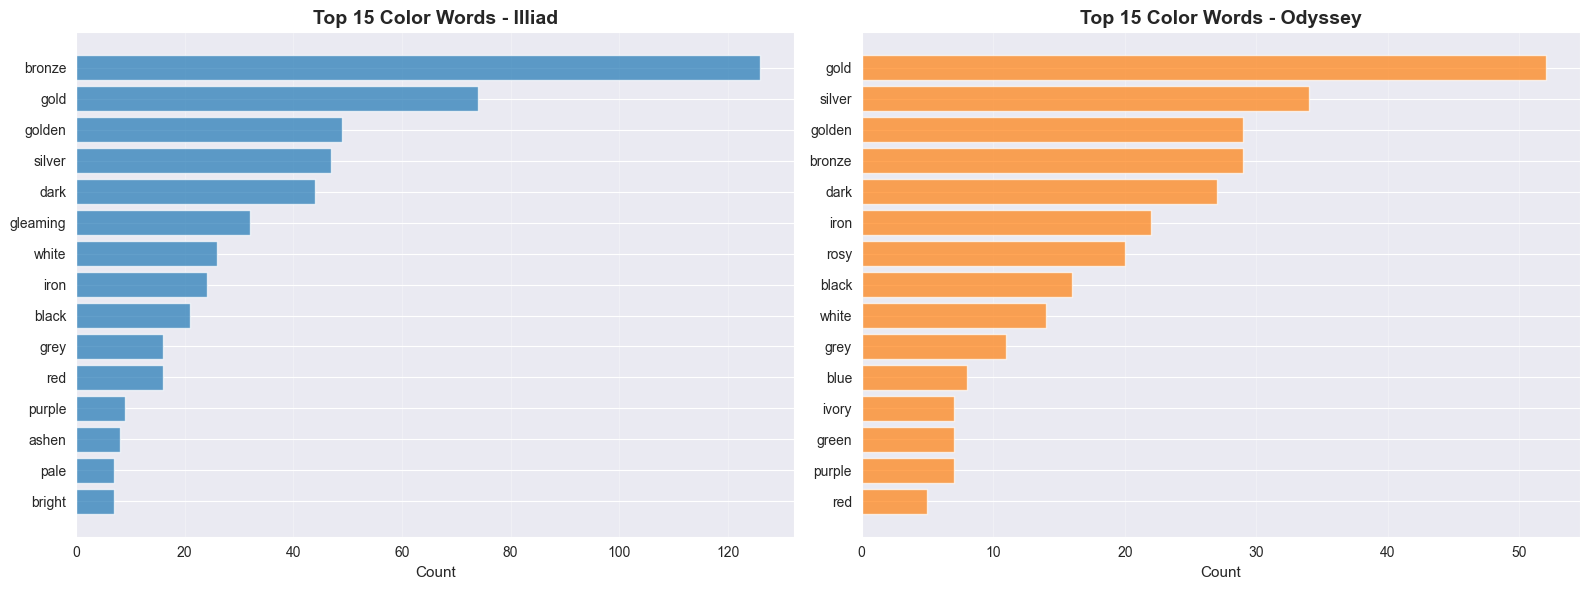

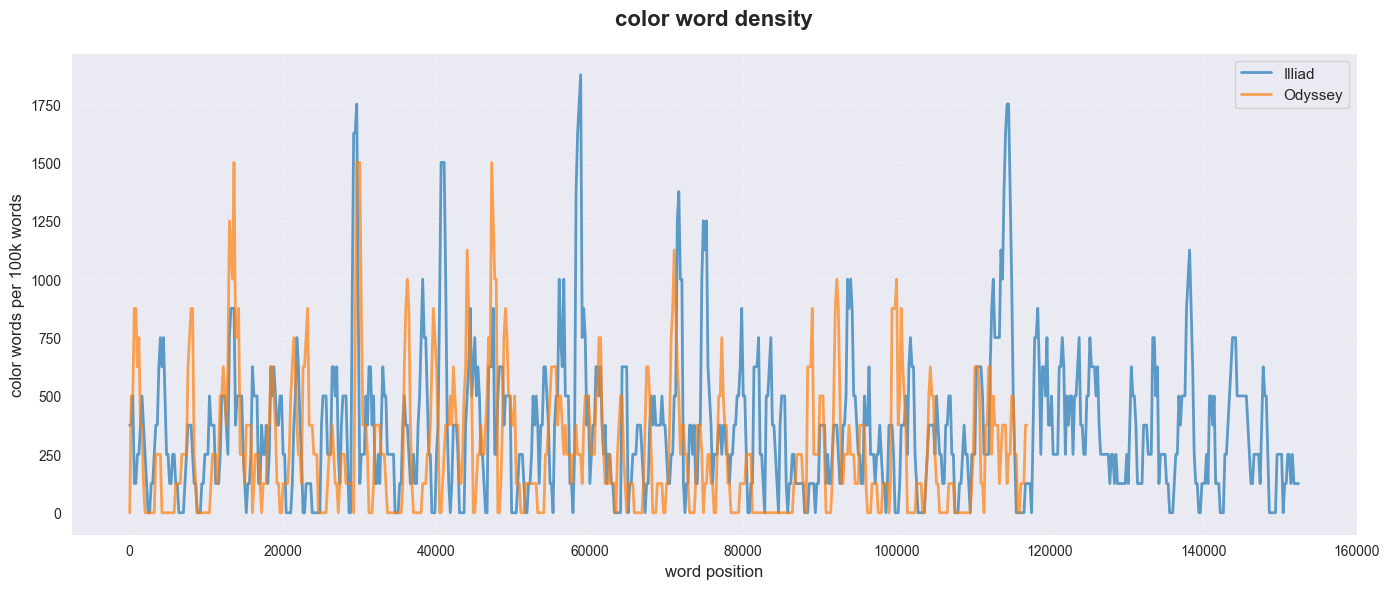

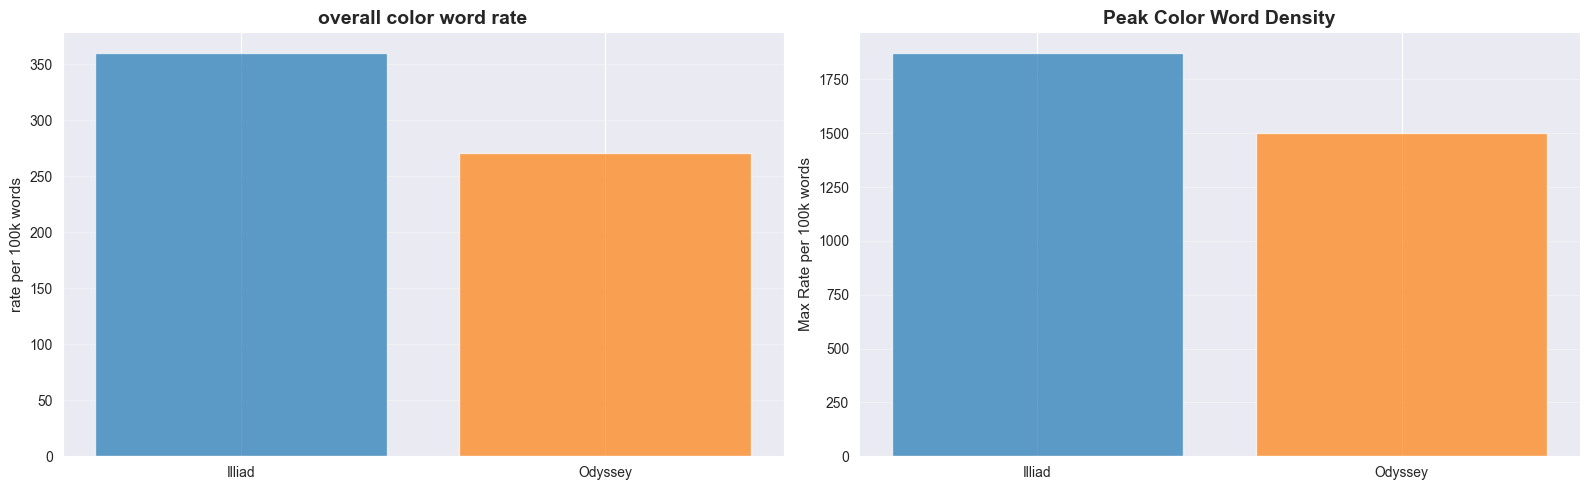

In [37]:
import matplotlib.pyplot as plt
import pandas as pd

def rolling_color_windows(tokens, window=800, step=200, color_list=None):
    if color_list is None:
        color_list = COLOR_LIST
    hits_per_window = []
    for i in range(0, max(1, len(tokens)-window+1), step):
        chunk = tokens[i:i+window]
        c = sum(1 for w in chunk if w in color_list)
        hits_per_window.append((i, i+window, c, c * (100000/window)))
    return hits_per_window

i_roll = rolling_color_windows(illiad_words, window=800, step=200)
o_roll = rolling_color_windows(odyssey_words, window=800, step=200)

# Create DataFrames
illiad_df = pd.DataFrame(i_roll, columns=['start', 'end', 'hits', 'rate_per_100k'])
odyssey_df = pd.DataFrame(o_roll, columns=['start', 'end', 'hits', 'rate_per_100k'])

# Top color words bar chart
i_top = pd.DataFrame(i_c.most_common(15), columns=['word', 'count'])
o_top = pd.DataFrame(o_c.most_common(15), columns=['word', 'count'])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

ax1.barh(i_top['word'][::-1], i_top['count'][::-1], color='#1f77b4', alpha=0.7)
ax1.set_title('Top 15 Color Words - Illiad', fontsize=14, fontweight='bold')
ax1.set_xlabel('Count', fontsize=11)
ax1.grid(True, alpha=0.3, axis='x')

ax2.barh(o_top['word'][::-1], o_top['count'][::-1], color='#ff7f0e', alpha=0.7)
ax2.set_title('Top 15 Color Words - Odyssey', fontsize=14, fontweight='bold')
ax2.set_xlabel('Count', fontsize=11)
ax2.grid(True, alpha=0.3, axis='x')

plt.savefig("../results/figures/CW_Color_words_bar_chart.png", dpi=300, bbox_inches="tight")
plt.tight_layout()
plt.show()
plt.close()

# Combined line plot
fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(illiad_df['start'], illiad_df['rate_per_100k'], label='Illiad', linewidth=2, alpha=0.7)
ax.plot(odyssey_df['start'], odyssey_df['rate_per_100k'], label='Odyssey', linewidth=2, alpha=0.7)

ax.set_title('color word density', fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('word position', fontsize=12)
ax.set_ylabel('color words per 100k words', fontsize=12)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3, linestyle='--')

plt.savefig("../results/figures/CW_Color_words_combine_line_plot.png", dpi=300, bbox_inches="tight")
plt.tight_layout()
plt.show()
plt.close()

# Summary statistics bar chart
summary_df = pd.DataFrame({
    'Text': ['Illiad', 'Odyssey'],
    'Mean Rate': [illiad_df['rate_per_100k'].mean(), odyssey_df['rate_per_100k'].mean()],
    'Max Rate': [illiad_df['rate_per_100k'].max(), odyssey_df['rate_per_100k'].max()],
    'Overall Rate': [(i_hits/i_total)*100000, (o_hits/o_total)*100000]
})

fig, (ax1, ax3) = plt.subplots(1, 2, figsize=(16, 5))

# Overall rate comparison
ax1.bar(summary_df['Text'], summary_df['Overall Rate'], color=['#1f77b4', '#ff7f0e'], alpha=0.7)
ax1.set_title('overall color word rate', fontsize=14, fontweight='bold')
ax1.set_ylabel('rate per 100k words', fontsize=11)
ax1.grid(True, alpha=0.3, axis='y')

# Max rate comparison
ax3.bar(summary_df['Text'], summary_df['Max Rate'], color=['#1f77b4', '#ff7f0e'], alpha=0.7)
ax3.set_title('Peak Color Word Density', fontsize=14, fontweight='bold')
ax3.set_ylabel('Max Rate per 100k words', fontsize=11)
ax3.grid(True, alpha=0.3, axis='y')

plt.savefig("../results/figures/CW_Color_words_Overall_Mean_Max_rate_comparison.png", dpi=300, bbox_inches="tight")
plt.tight_layout()
plt.show()
plt.close()